In [16]:
# Import libraries for this project
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from datetime import datetime
from pprint import pprint
from time import time
import logging
from sklearn.model_selection import train_test_split
# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

#SK-learn libraries for transformation and pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

#Seaboarn for EDA
import seaborn as sns

# W207 Final Project
## Bike Sharing Demand Kaggle Competition
Team Members: Zach Ingbretsen, Nicholas Chen, Keri Wheatley, and Rob Mulla

Kaggle Link: https://www.kaggle.com/c/bike-sharing-demand

## Business Understanding
* What problem are we trying solve?
* What are the relevant metrics? How much do we plan to improve them?
* What will we deliver?


## Data Understanding

- What are the raw data sources?

The data sources for this project are provided by kaggle. A train and test set and a example solution submission. https://www.kaggle.com/c/bike-sharing-demand

- What does each 'unit' (e.g. row) of data represent?

In [61]:
train_df = pd.read_csv('data/train.csv', index_col=0, infer_datetime_format=True)
train_df.index.name=None # Remove index name to remove confusing datetime column
train_df.index = pd.to_datetime(train_df.index) # Convert index to datetime
test_df = pd.read_csv('data/test.csv', index_col=0, infer_datetime_format=True)
test_df.index.name=None # Remove index name to remove confusing datetime column
test_df.index = pd.to_datetime(test_df.index) # Convert index to datetime

### What are the fields (columns)?

**datetime** - hourly date + timestamp  

**season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

**holiday** - whether the day is considered a holiday

**workingday** - whether the day is neither a weekend nor holiday

**weather** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

**temp** - temperature in Celsius

**atemp** - "feels like" temperature in Celsius

**humidity** - relative humidity

**windspeed** - wind speed

**casual** - number of non-registered user rentals initiated

**registered** - number of registered user rentals initiated

**count** - number of total rentals

In [62]:
boolean_fields = ['season','holiday','workingday','weather']
other_fields = ['temp','atemp','humidity','windspeed','casual','registered','count']
other_fields_reduced = ['atemp','humidity','windspeed','count']

train_df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [63]:
test_df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


## EDA
### Distribution of each feature

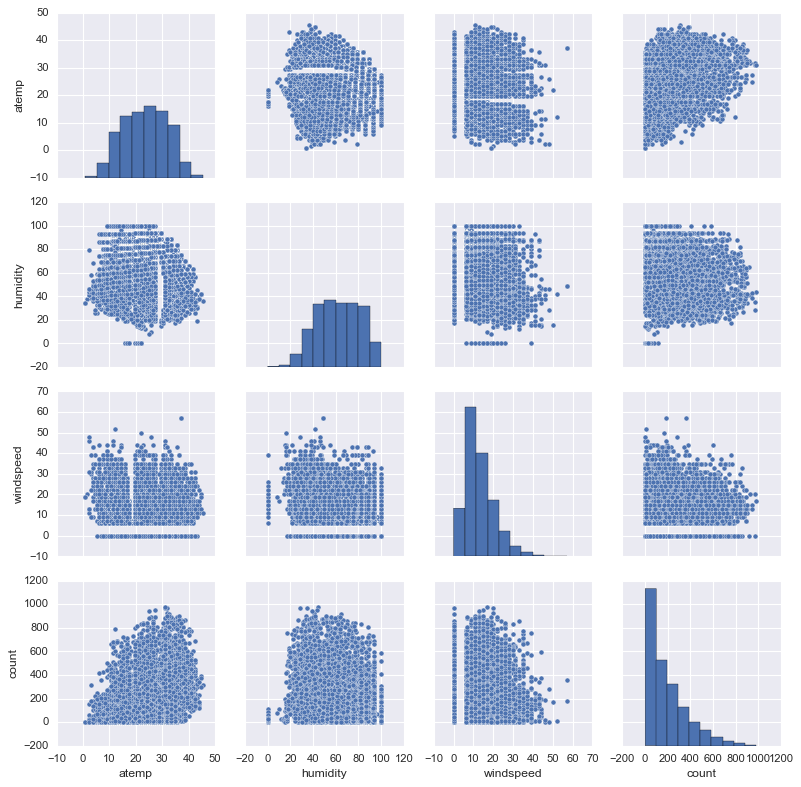

In [127]:
# Scatterplot
sns.pairplot(train_df[other_fields_reduced]);

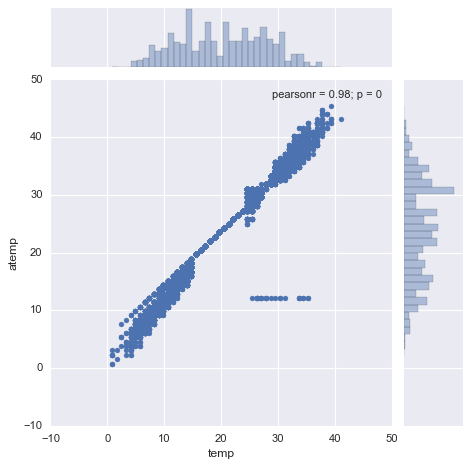

In [65]:
# This is strange what is the line?
sns.jointplot(x="temp", y="atemp", data=train_df);

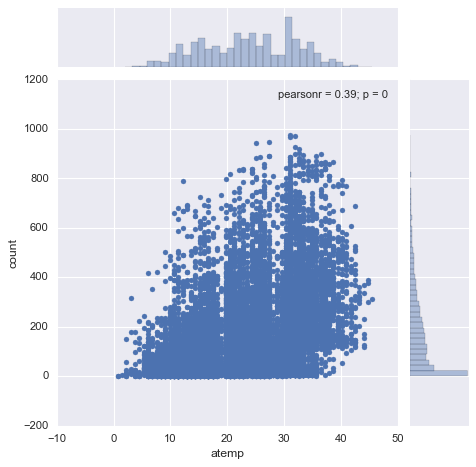

In [66]:
# Temp vs Riders Color of rider type
sns.jointplot(x="atemp", y="count", data=train_df);

In [104]:
# Add hour column

def transform_variables(df):
    df['hour'] = df.index.hour
    df['weekday name'] = df.index.weekday_name
    df['weekday'] = df.index.weekday
    df['weekofyear'] = df.index.weekofyear
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['month'] = df.index.month
    return df
    
train_df_mod = transform_variables(train_df)

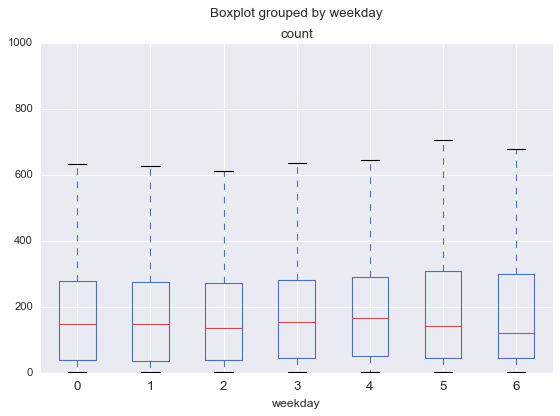

In [110]:
#tran_train_matrix = transform_variables(train_matrix)
train_df.boxplot('count','weekday')

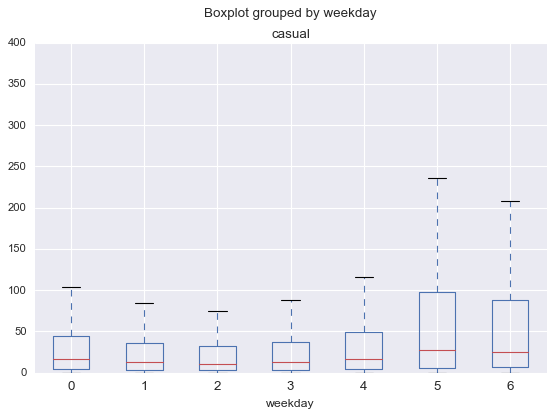

In [111]:
train_df.boxplot('casual','weekday')

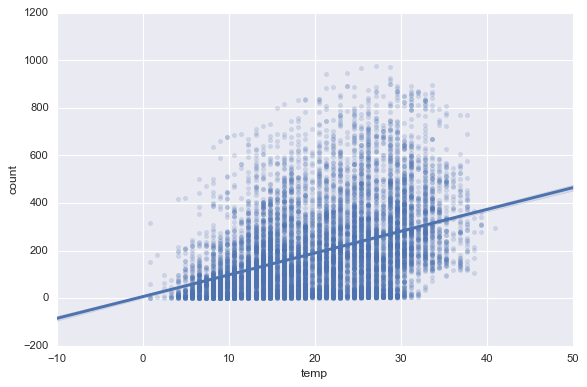

In [102]:
# Seaborn scatter plot with regression line
sns.lmplot(x='temp', y='count', data=train_df, aspect=1.5, scatter_kws={'alpha':0.2})

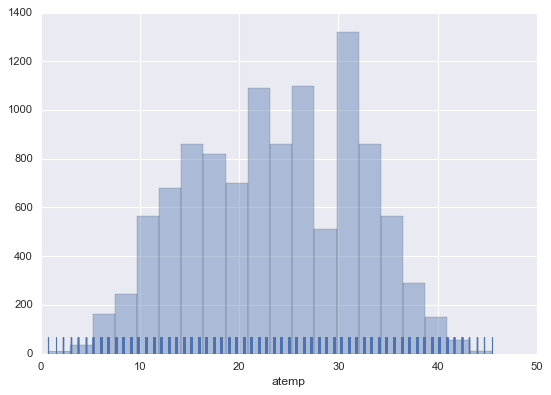

In [51]:
# Explore the temperature
sns.distplot(train_df.atemp, bins=20, kde=False, rug=True);

In [103]:
pd.crosstab(train_df.season, train_df.index.month)

col_0,1,2,3,4,5,6,7,8,9,10,11,12
season,,,,,,,,,,,,
1,884,901,901,0,0,0,0,0,0,0,0,0
2,0,0,0,909,912,912,0,0,0,0,0,0
3,0,0,0,0,0,0,912,912,909,0,0,0
4,0,0,0,0,0,0,0,0,0,911,911,912


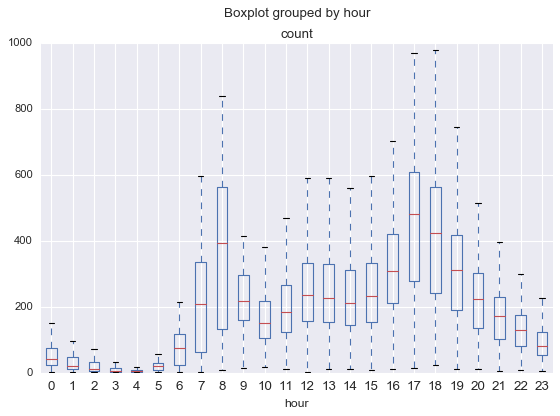

In [116]:
train_df.boxplot('count','hour', )

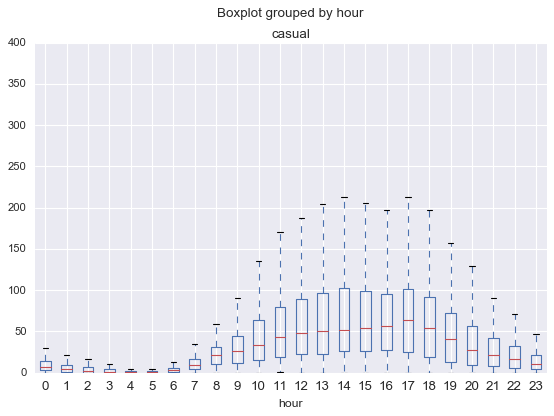

In [117]:
train_df.boxplot('casual','hour', )

### Missing values
### Distribution of target

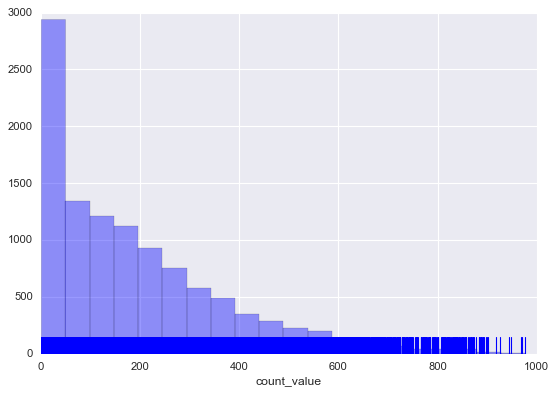

In [133]:
train_df['count_value'] = train_df['count']
sns.distplot(train_df.count_value, bins=20, kde=False, rug=True, color='b');

  - Relationships between features
  - Other idiosyncracies?

## Data Preparation

- What steps are taken to prepare the data for modeling?
  - feature transformations? engineering?
  - table joins? aggregation?
- Precise description of modeling base tables.
  - What are the rows/columns of X (the predictors)?
  - What is y (the target)?

## Modeling

- What model are we using? Why?
- Assumptions?
- Regularization?

## Evaluation

- How well does the model perform?
  - Accuracy
  - ROC curves
  - Cross-validation
  - other metrics? performance?

- AB test results (if any)

## Deployment

- How is the model deployed?
  - prediction service?
  - serialized model?
  - regression coefficients?
- What support is provided after initial deployment?